# Run this to use the tarfile and os module to extract .tar data

In [1]:
import tarfile
import os

In [2]:
os.listdir(os.getcwd())

['iccv09Data',
 '.ipynb_checkpoints',
 'data_exploration.ipynb',
 'Plotting acc val.ipynb']

In [3]:
data_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'data', 'iccv09Data.tar.gz'))

In [4]:
data = tarfile.open(data_path, mode = 'r')

In [6]:
data.extractall(path = os.path.abspath(os.path.join(os.getcwd(), '..', 'data')))

# Data Visualization
## Some notes:
README FOR ICCV09DATA

This dataset contains 715 images sourced from LabelMe, MSRC, PASCAL
VOC, and Geometric Context. Labels were obtained using Amazon's
Mechanical Turk (AMT). The labels are:

  - horizons.txt         : image dimensions and location of horizon
  - labels/*.regions.txt : integer matrix indicating each pixel's
                           semantic class (sky, tree, road, grass,
                           water, building, mountain, or foreground
                           object). A negative number indicates
                           unknown.
 - labels/*.surfaces.txt : integer matrix indicating each pixel's
                           geometric class (sky, horizontal, or
                           vertical).
 - labels/*.layers.txt   : integer matrix indicating distinct
                           image regions.

If you use this data, please cite our ICCV 2009 paper:

 - Decomposing a Scene into Geometric and Semantically Consistent Regions
   Stephen Gould, Richard Fulton, Daphne Koller, ICCV 2009

Stephen Gould
sgould@stanford.edu

In [2]:
%matplotlib notebook
# %matplotlib inline
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [3]:
data_path = os.path.join(os.getcwd(),'..','data','raw')
image_path = os.path.join(data_path, 'images')
label_path = os.path.join(data_path, 'labels')

In [4]:
all_imgs = []
all_regions = []
all_surfaces = []
all_layers = []

for i in os.listdir(image_path):
    all_imgs.append(os.path.join(image_path, i))

for i in os.listdir(label_path):
    if 'surfaces.txt' in i:
        all_surfaces.append(os.path.join(label_path, i))
    elif 'regions.txt' in i:
        all_regions.append(os.path.join(label_path, i))
    elif 'layers.txt' in i:
        all_layers.append(os.path.join(label_path, i))
    else:
        print('Error. funny file named: ', i)

all_imgs.sort()
all_regions.sort()
all_surfaces.sort()
all_layers.sort()
print(len(all_imgs))
print(len(all_regions))
print(len(all_surfaces))
print(len(all_layers))

715
715
715
715


In [5]:
def convert_to_csv(file):
    numbers_we_care = ['0','1','2','3','4','5','6','7','8','9','10']
    temp = []
    for i in file.readlines():
        for j in i:
            if j in numbers_we_care:
                temp.append(int(j))
    temp = np.array(temp)
    return temp

In [1]:
# image_num = 27
image_num = np.random.randint(0,715)
img = all_imgs[image_num]
tag_num = img.split('/')[-1].split('.')[0]
print(tag_num)
reg = all_regions[image_num]
surf = all_surfaces[image_num]
lay = all_layers[image_num]

print(img)
print(reg)
print(surf)
print(lay)

reg = open(reg, 'r')
reg = convert_to_csv(reg)
reg = reg.reshape(plt.imread(img).shape[:2])

surf = open(surf, 'r')
surf = convert_to_csv(surf)
surf = surf.reshape(plt.imread(img).shape[:2])

# lay = open(lay, 'r')
# lay = convert_to_csv(lay)
# lay = lay.reshape(plt.imread(img).shape[:2])

NameError: name 'np' is not defined

<IPython.core.display.Javascript object>


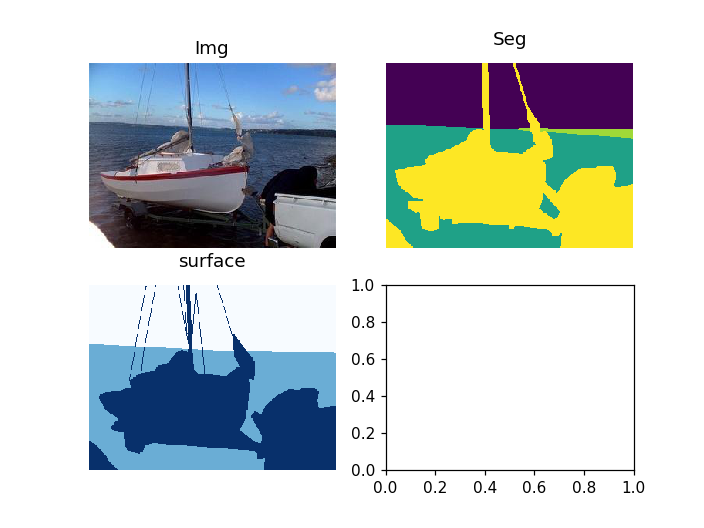

Text(0.5,1.05,'surface')

In [12]:
fig, ax = plt.subplots(2,2)
ax[0,0].imshow(plt.imread(img))
ax[0,0].set_axis_off()
ax[0,0].set_title('Img')

ax[0,1].matshow(reg)
ax[0,1].set_axis_off()
ax[0,1].set_title('Seg')

ax[1,0].matshow(surf, cmap = plt.cm.Blues)
ax[1,0].set_axis_off()
ax[1,0].set_title('surface')

# Preparing Training Data

In [ ]:
train_imgs = []
train_regions = []

for i in range(len(all_imgs)):
    test = plt.imread(all_imgs[i])
    if test.shape == (240,320,3):
#         train_imgs.append(all_imgs[i])
        train_imgs.append(plt.imread(all_imgs[i]))
        train_regions.append(all_regions[i])

print(len(train_imgs))
print(len(train_regions))

In [ ]:
image_num = np.random.randint(0,531)
# image_num = 0
print('image_num: ', image_num)
# print(train_imgs[image_num])
# print(train_regions[image_num])
fig, ax = plt.subplots(1,2)

ax[0].imshow((train_imgs[image_num]))
ax[0].set_axis_off()
ax[0].set_title('Img')

reg = convert_to_csv(open(train_regions[image_num], 'r')).reshape(240,320)
ax[1].matshow(reg)
ax[1].set_axis_off()
ax[1].set_title('Seg')

text = '0: sky \n1: tree \n2: road\n3: grass\n4: water\n5: building\n6: mountain\n7: foreground'
fig.text(0.91,0.5,text)


In [ ]:
from keras.utils import to_categorical

all_imgs = np.array(train_imgs)
all_masks = []
for i in train_regions:
    all_masks.append(convert_to_csv(open(i, 'r')).reshape(240,320))
all_masks = np.array(all_masks)
all_masks_oneHot = to_categorical(all_masks, 8)
print(all_imgs.shape)
print(all_masks_oneHot.shape)



# Checking code
# mask = mask.reshape(())
# for lay in range(mask[0].shape[-1]):
#     masks_layers = first_masks_onehot[:,:,lay]
#     print("layer num: ", text.split('\n')[lay])
#     print(masks_layers.shape)
#     plt.matshow(masks_layers)

# UNet

In [ ]:
import keras
from keras.models import Model
from keras.layers import Conv2D, UpSampling2D, MaxPooling2D, Dropout, Cropping2D, Input, merge
from keras.optimizers import SGD, Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard
from keras import backend as keras # want the Keras modules to be compatible 

def UNet(filters_dims, activation='relu', kernel_initializer='glorot_uniform', padding='same'):
    inputs = Input((240, 320, 3))
    new_inputs = inputs
    conv_layers = []
    # Encoding Phase
    print("Encoding Phase")
    for i in range(len(filters_dims) - 1):
        print("Stage :", i+1)
        print("========================================")
        print(new_inputs.shape)
        conv = Conv2D(filters_dims[i], 3, activation=activation, padding=padding,
                      kernel_initializer=kernel_initializer)(new_inputs)
        conv = Conv2D(filters_dims[i], 3, activation=activation, padding=padding,
                      kernel_initializer=kernel_initializer)(conv)
        conv_layers.append(conv)
        new_inputs = MaxPooling2D(pool_size=(2, 2))(conv)
        print(new_inputs.shape)
        # op = BatchNormalization()(op)

    # middle phase
    print("middle phase")
    print("========================================")
    conv = Conv2D(filters_dims[-1], 3, activation=activation, padding=padding,
                  kernel_initializer=kernel_initializer)(new_inputs)
    conv = Conv2D(filters_dims[-1], 3, activation=activation, padding=padding,
                  kernel_initializer=kernel_initializer)(conv)
    new_inputs = Dropout(0.5)(conv)
    print(new_inputs.shape)

    filters_dims.reverse()
    conv_layers.reverse()

    # Decoding Phase
    print("Decoding Phase")
    for i in range(1, len(filters_dims)):
        print(i)
        print("========================================")

        print(new_inputs.shape)
        up = Conv2D(filters_dims[i], 3, activation=activation, padding=padding,
                    kernel_initializer=kernel_initializer)(UpSampling2D(size=(2, 2))(new_inputs))
        concat = merge([conv_layers[i-1], up], mode='concat', concat_axis=3)
        conv = Conv2D(filters_dims[i], 3, activation=activation, padding=padding,
                      kernel_initializer=kernel_initializer)(concat)
        new_inputs = Conv2D(filters_dims[i], 3, activation=activation, padding=padding,
                            kernel_initializer=kernel_initializer)(conv)
        print(new_inputs.shape)
    outputs = Conv2D(8, 1, activation='softmax', padding='same',
                     kernel_initializer='glorot_uniform')(new_inputs)
    print(outputs.shape)
    model = Model(input=inputs, output=outputs, name='UNet')
    model.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
filters_dims = [64, 128, 256, 512]
model_1 = UNet(filters_dims)

In [ ]:
# filters_dims = [64, 128, 256, 512,1024]
# model_2 = UNet(filters_dims)

In [ ]:
def train(model):
    
    batchSz = 2
    num_epochs = 1
    print("Getting data.. Image shape: {}. Masks shape : {}".format(all_imgs.shape,
                                                                         all_masks.shape))
    print("The data will be split to Train Val: 80/20")
#     split_index = round(len(all_imgs)*0.8)
#     train_img = all_imgs[:split_index]
#     test_img = all_imgs[split_index:]
#     train_mask = all_masks[:split_index]
#     test_mask = all_masks[split_index:]
    
#     assert (len(train_img) + len(test_img)) == len(all_imgs)
#     assert (len(train_mask) + len(test_mask)) == len(all_masks)
    
#     print("Training image: ", train_img.shape)
#     print("Training mask: ", train_mask.shape)
#     print("Testing image: ", test_img.shape)
#     print("Testing image: ", test_mask.shape)
    
    
    filepath = 'weights/' + model.name + '.{epoch:02d}-{loss:.2f}.hdf5'
    checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_weights_only=True, save_best_only=True, mode='auto', period=1)
    tensor_board = TensorBoard(log_dir='logs/', histogram_freq=1, batch_size=batchSz,
                              write_grads=True, write_images=True)
    history = model.fit(x=all_imgs, y=all_masks_oneHot, batch_size=batchSz, epochs=num_epochs, verbose=1, callbacks=[checkpoint, tensor_board], validation_split=0.2)
    
    return history
    

In [ ]:
# Training

results = train(model_2)

# For GIFs

In [ ]:
weights_path = os.path.join(os.getcwd(),'weights')
weights_path_forgif = os.path.join(weights_path, 'for_gif')

list_of_weights = os.listdir(weights_path_forgif)
list_of_weights.sort()
list_of_weights

In [ ]:
image_num = np.random.randint(0,len(all_imgs))
print("image num: ", image_num)

In [ ]:
weights_num = 0
print(list_of_weights[weights_num])
model_1.load_weights(os.path.join(weights_path_forgif, list_of_weights[weights_num]))

In [ ]:
pred1 = model_1.predict(all_imgs[image_num:image_num+1])[0]

combined_pred1 = np.zeros(pred1.shape[:-1])
for lays in range(pred1.shape[-1]):
    combined_pred1 += np.round(pred1[:,:,lays])* lays

In [ ]:
epoch = str(list_of_weights[weights_num].split(".")[1].split("-")[0])
loss = str(list_of_weights[weights_num].split(".")[1].split("-")[1] + "." + list_of_weights[weights_num].split(".")[2])

print(epoch)
print(loss)

In [ ]:
# for plotting (layers analysis)
img = all_imgs[image_num]
mask = all_masks[image_num]
lay = 1
fig, ax = plt.subplots(2,2)

ax[0,0].imshow((img))
ax[0,0].set_axis_off()
ax[0,0].set_title('Img')

ax[0,1].matshow(mask)
ax[0,1].set_axis_off()
ax[0,1].set_title('Ground Truth Seg')

ax[1,0].matshow(combined_pred1)
ax[1,0].set_axis_off()
ax[1,0].set_title('Pred Seg model1')

ax[1,1].set_axis_off()

text = '0: sky \n1: tree \n2: road\n3: grass\n4: water\n5: building\n6: mountain\n7: foreground'
fig.text(0.65,0.1,text)
fig.text(0.7,0.37,"Loss: {}".format(loss))
fig.text(0.65,0.4,"Epoch: {}".format(epoch),fontsize=20, fontweight='bold')

fig.savefig("result_epoch1.png")

In [ ]:
for i in range(len(list_of_weights)):

    weights_num = i
    print(list_of_weights[weights_num])
    model_1.load_weights(os.path.join(weights_path_forgif, list_of_weights[weights_num]))

    pred1 = model_1.predict(all_imgs[image_num:image_num+1])[0]

    combined_pred1 = np.zeros(pred1.shape[:-1])
    for lays in range(pred1.shape[-1]):
        combined_pred1 += np.round(pred1[:,:,lays])* lays

    epoch = str(list_of_weights[weights_num].split(".")[1].split("-")[0])
    loss = str(list_of_weights[weights_num].split(".")[1].split("-")[1] + "." + list_of_weights[weights_num].split(".")[2])

    print(epoch)
    print(loss)

    # for plotting (layers analysis)
    img = all_imgs[image_num]
    mask = all_masks[image_num]
    lay = 1
    fig, ax = plt.subplots(2,2)

    ax[0,0].imshow((img))
    ax[0,0].set_axis_off()
    ax[0,0].set_title('Img')

    ax[0,1].matshow(mask)
    ax[0,1].set_axis_off()
    ax[0,1].set_title('Ground Truth Seg')

    ax[1,0].matshow(combined_pred1)
    ax[1,0].set_axis_off()
    ax[1,0].set_title('Pred Seg model1')

    ax[1,1].set_axis_off()

    text = '0: sky \n1: tree \n2: road\n3: grass\n4: water\n5: building\n6: mountain\n7: foreground'
    fig.text(0.65,0.1,text)
    fig.text(0.7,0.37,"Loss: {}".format(loss))
    fig.text(0.65,0.4,"Epoch: {}".format(epoch),fontsize=20, fontweight='bold')

    fig.savefig("result_epoch{}.png".format(epoch))
    print("Figure saved as: result_epoch{}.png".format(epoch))

# Testing

In [ ]:
weights_path = os.path.join(os.getcwd(),'weights')
weights_path_forgif = os.path.join(weights_path, 'for_gif')

list_of_weights = os.listdir(weights_path_forgif)
list_of_weights.sort()
list_of_weights

In [ ]:
weights_num = 0

model_1.load_weights(os.path.join(weights_path_forgif, list_of_weights[weights_num]))

In [ ]:
# for plotting (layers analysis)
img = all_imgs[image_num]
mask_oneHot = all_masks_oneHot[image_num]
lay = 1
fig, ax = plt.subplots(2,3)

ax[0,0].imshow((img))
ax[0,0].set_axis_off()
ax[0,0].set_title('Img')

ax[0,1].matshow(mask_oneHot[:,:,lay])
ax[0,1].set_axis_off()
ax[0,1].set_title('Ground Truth Seg')

ax[1,0].matshow(np.round(pred1[:,:,lay]))
ax[1,0].set_axis_off()
ax[1,0].set_title('Pred Seg model1')

ax[1,1].matshow(np.round(pred2[:,:,lay]))
ax[1,1].set_axis_off()
ax[1,1].set_title('Pred Seg model2')

ax[1,2].matshow(np.round(pred3[:,:,lay]))
ax[1,2].set_axis_off()
ax[1,2].set_title('Pred Seg model3')

ax[0,2].matshow(np.round(pred4[:,:,lay]))
ax[0,2].set_axis_off()
ax[0,2].set_title('Pred Seg model4')

text = '0: sky \n1: tree \n2: road\n3: grass\n4: water\n5: building\n6: mountain\n7: foreground'
fig.text(0.91,0.5,text)

In [ ]:
# loading the weights
counter = 0
lowest_loss = 10.0
weights_path = os.path.join(os.getcwd(),'weights')
weights_path1 = os.path.join(weights_path, 'first_training_epoch10')
weights_path2 = os.path.join(weights_path, 'fifth_training_epoch50_UNET_5_stage')
# weights_path3 = os.path.join(weights_path, 'third_training_epoch50_sigmoid')
# weights_path4 = os.path.join(weights_path, 'fourth_training_epoch50_softmax')


for weights in os.listdir(weights_path1):
    
    if float(weights.split('hdf5')[0].split('-')[-1][:-1]) <= lowest_loss:
        lowest_loss = float(weights.split('hdf5')[0].split('-')[-1][:-1])
        best_weights1 = os.listdir(weights_path1)[counter]
    counter +=1
    print(counter)
    print('best_weights1: ', best_weights1)

lowest_loss = 10.0
counter = 0
for weights in os.listdir(weights_path2):
    
    if float(weights.split('hdf5')[0].split('-')[-1][:-1]) <= lowest_loss:
        lowest_loss = float(weights.split('hdf5')[0].split('-')[-1][:-1])
        best_weights2 = os.listdir(weights_path2)[counter]
    counter +=1
    print(counter)
    print('best_weights2: ', best_weights2)
    
# lowest_loss = 10.0
# counter = 0
# for weights in os.listdir(weights_path3):
    
#     if float(weights.split('hdf5')[0].split('-')[-1][:-1]) <= lowest_loss:
#         lowest_loss = float(weights.split('hdf5')[0].split('-')[-1][:-1])
#         best_weights3 = os.listdir(weights_path3)[counter]
#     counter +=1
#     print(counter)
#     print('best_weights3: ', best_weights3)
    
# lowest_loss = 10.0
# counter = 0
# for weights in os.listdir(weights_path4):
    
#     if float(weights.split('hdf5')[0].split('-')[-1][:-1]) <= lowest_loss:
#         lowest_loss = float(weights.split('hdf5')[0].split('-')[-1][:-1])
#         best_weights4 = os.listdir(weights_path4)[counter]
#     counter +=1
#     print(counter)
#     print('best_weights4: ', best_weights4)

In [ ]:
model_2.load_weights(os.path.join(weights_path2, best_weights2))

In [ ]:
model_1.load_weights(os.path.join(weights_path1, best_weights1))
# model_2.load_weights(os.path.join(weights_path2, best_weights2))
# model_3.load_weights(os.path.join(weights_path3, best_weights3))
# model_4.load_weights(os.path.join(weights_path4, best_weights4))

In [ ]:
len(all_imgs)

In [ ]:
image_num = np.random.randint(0,len(all_imgs))
print("image num: ", image_num)
pred1 = model_1.predict(all_imgs[image_num:image_num+1])[0]
pred2 = model_2.predict(all_imgs[image_num:image_num+1])[0]
pred3 = model_3.predict(all_imgs[image_num:image_num+1])[0]
pred4 = model_4.predict(all_imgs[image_num:image_num+1])[0]

In [ ]:
# print(pred1.shape)
# print(pred1[0,0,:].sum())
# print(pred1[1,0,:])
print(pred3.shape)
print(pred3[0,0,:].sum())
print(pred3[1,0,:])
print(pred4.shape)
print(pred4[0,0,:].sum())
print(pred4[1,0,:])

In [ ]:
# for plotting (layers analysis)
img = all_imgs[image_num]
mask_oneHot = all_masks_oneHot[image_num]
lay = 1
fig, ax = plt.subplots(2,3)

ax[0,0].imshow((img))
ax[0,0].set_axis_off()
ax[0,0].set_title('Img')

ax[0,1].matshow(mask_oneHot[:,:,lay])
ax[0,1].set_axis_off()
ax[0,1].set_title('Ground Truth Seg')

ax[1,0].matshow(np.round(pred1[:,:,lay]))
ax[1,0].set_axis_off()
ax[1,0].set_title('Pred Seg model1')

ax[1,1].matshow(np.round(pred2[:,:,lay]))
ax[1,1].set_axis_off()
ax[1,1].set_title('Pred Seg model2')

ax[1,2].matshow(np.round(pred3[:,:,lay]))
ax[1,2].set_axis_off()
ax[1,2].set_title('Pred Seg model3')

ax[0,2].matshow(np.round(pred4[:,:,lay]))
ax[0,2].set_axis_off()
ax[0,2].set_title('Pred Seg model4')

text = '0: sky \n1: tree \n2: road\n3: grass\n4: water\n5: building\n6: mountain\n7: foreground'
fig.text(0.91,0.5,text)

In [ ]:
all_masks[image_num].shape

In [ ]:
# Combining the layers together
combined_pred1 = np.zeros(pred1.shape[:-1])
for lays in range(pred1.shape[-1]):
    combined_pred1 += np.round(pred1[:,:,lays])* lays

combined_pred2 = np.zeros(pred2.shape[:-1])
for lays in range(pred2.shape[-1]):
    combined_pred2 += np.round(pred2[:,:,lays])* lays

combined_pred3 = np.zeros(pred3.shape[:-1])
for lays in range(pred3.shape[-1]):
    combined_pred3 += np.round(pred3[:,:,lays])* lays
    
combined_pred4 = np.zeros(pred4.shape[:-1])
for lays in range(pred4.shape[-1]):
    combined_pred4 += np.round(pred4[:,:,lays])* lays

# combined_pred1 + np.round(pred1[:,:,0])
    
mask = all_masks[image_num]
fig,ax = plt.subplots(2,3)

ax[0,0].imshow((all_imgs[image_num]))
ax[0,0].set_axis_off()
ax[0,0].set_title('Img')

ax[0,1].matshow(mask)
ax[0,1].set_axis_off()
ax[0,1].set_title('Ground Truth Seg')

ax[1,0].matshow(combined_pred1)
ax[1,0].set_axis_off()
ax[1,0].set_title('Pred Seg model1')

ax[1,1].matshow(combined_pred2)
ax[1,1].set_axis_off()
ax[1,1].set_title('Pred Seg model2')

ax[1,2].matshow(combined_pred3)
ax[1,2].set_axis_off()
ax[1,2].set_title('Pred Seg model3')

ax[0,2].matshow(combined_pred4)
ax[0,2].set_axis_off()
ax[0,2].set_title('Pred Seg model4')


text = '0: sky \n1: tree \n2: road\n3: grass\n4: water\n5: building\n6: mountain\n7: foreground'
fig.text(0.91,0.5,text)
fig.savefig('pictures/result/Image-{}'.format(image_num))